In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bbcnewsarchive/bbc-news-data.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support)

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" All libraries imported successfully!")


 All libraries imported successfully!


In [8]:
import pandas as pd

df = pd.read_csv(
    '/kaggle/input/bbcnewsarchive/bbc-news-data.csv',
    sep='\t',          
    quotechar='"',
    on_bad_lines='skip'
)

if 'category' in df.columns and 'content' in df.columns:
    df.rename(columns={'category': 'Category', 'content': 'Text'}, inplace=True)
elif 'label' in df.columns and 'content' in df.columns:
    df.rename(columns={'label': 'Category', 'content': 'Text'}, inplace=True)

print("Columns:", df.columns.tolist())
print("Dataset shape:", df.shape)
print(df.head())


Columns: ['Category', 'filename', 'title', 'Text']
Dataset shape: (2225, 4)
   Category filename                              title  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   

                                                Text  
0   Quarterly profits at US media giant TimeWarne...  
1   The dollar has hit its highest level against ...  
2   The owners of embattled Russian oil giant Yuk...  
3   British Airways has blamed high fuel prices f...  
4   Shares in UK drinks and food firm Allied Dome...  


In [9]:
print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)

# 3.1 Basic Information
print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Dataset Statistics ---")
print(df.describe(include='all'))



EXPLORATORY DATA ANALYSIS

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   Text      2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB
None

--- Missing Values ---
Category    0
filename    0
title       0
Text        0
dtype: int64

--- Dataset Statistics ---
       Category filename                              title  \
count      2225     2225                               2225   
unique        5      511                               2096   
top       sport  385.txt  Doors open at biggest gadget fair   
freq        511        5                                  2   

                                                     Text  
count                                                2225  
unique        

In [10]:
print("\n--- Category Distribution ---")
category_counts = df['Category'].value_counts()
print(category_counts)
print(f"\nNumber of unique categories: {df['Category'].nunique()}")


--- Category Distribution ---
Category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Number of unique categories: 5


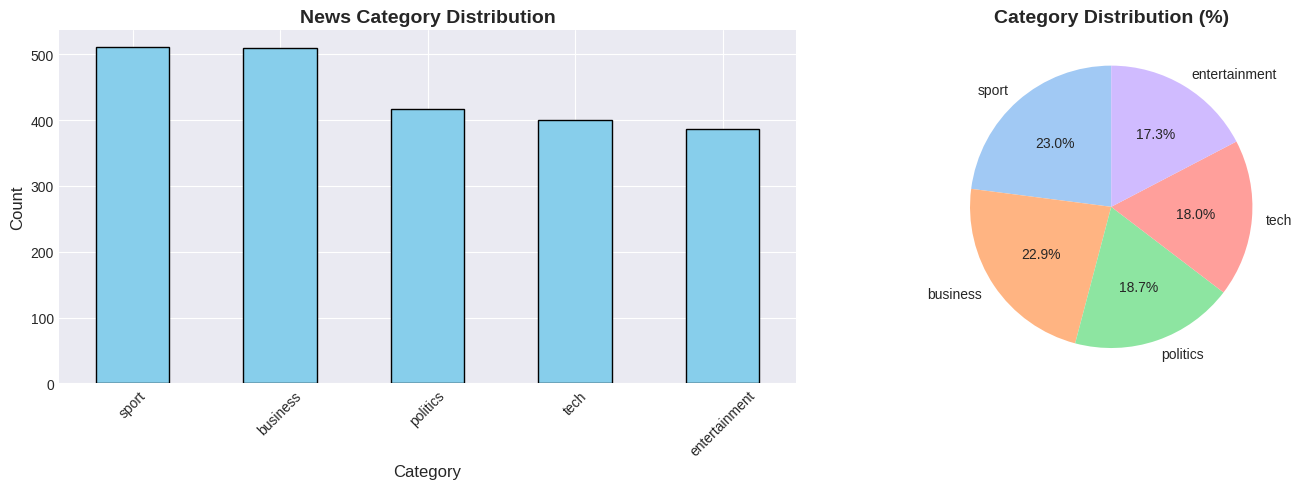

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
category_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('News Category Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
# Pie chart
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('pastel'))
axes[1].set_title('Category Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [18]:
df['text_length'] = df['Text'].apply(len)
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
df['sentence_count'] = df['Text'].apply(lambda x: len(str(x).split('.')))
df['avg_word_length'] = df['Text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

print("\n--- Text Statistics ---")
print(df[['text_length', 'word_count', 'sentence_count', 'avg_word_length']].describe())



--- Text Statistics ---
        text_length   word_count  sentence_count  avg_word_length
count   2225.000000  2225.000000     2225.000000      2225.000000
mean    2232.793258   378.835955       20.639551         4.899136
std     1364.249946   238.220755       12.354639         0.261320
min      471.000000    84.000000        5.000000         4.020231
25%     1414.000000   240.000000       14.000000         4.731579
50%     1936.000000   326.000000       19.000000         4.896703
75%     2774.000000   466.000000       25.000000         5.075718
max    25454.000000  4428.000000      246.000000         6.054264


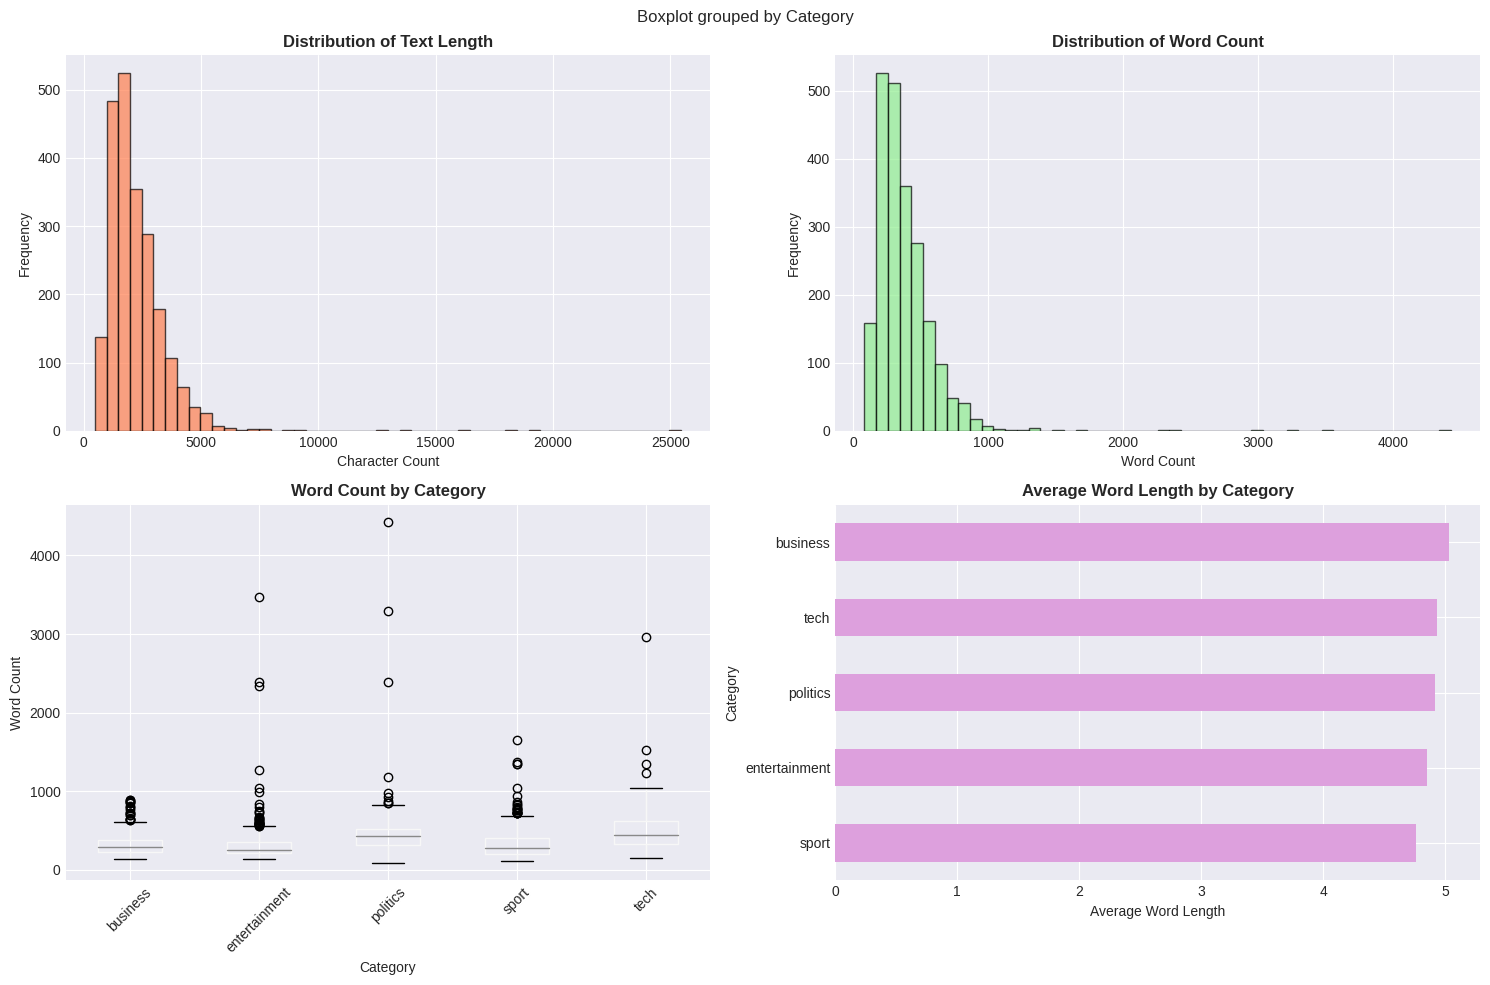

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text length distribution
axes[0, 0].hist(df['text_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Text Length', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')

# Word count distribution
axes[0, 1].hist(df['word_count'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Word Count', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')

# Box plot: Word count by category
df.boxplot(column='word_count', by='Category', ax=axes[1, 0])
axes[1, 0].set_title('Word Count by Category', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Category')
axes[1, 0].set_ylabel('Word Count')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)
# Avg word length by category
category_avg_word_length = df.groupby('Category')['avg_word_length'].mean().sort_values()
category_avg_word_length.plot(kind='barh', ax=axes[1, 1], color='plum')
axes[1, 1].set_title('Average Word Length by Category', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Average Word Length')
axes[1, 1].set_ylabel('Category')

plt.tight_layout()
plt.show()


--- Generating Word Clouds for Each Category ---


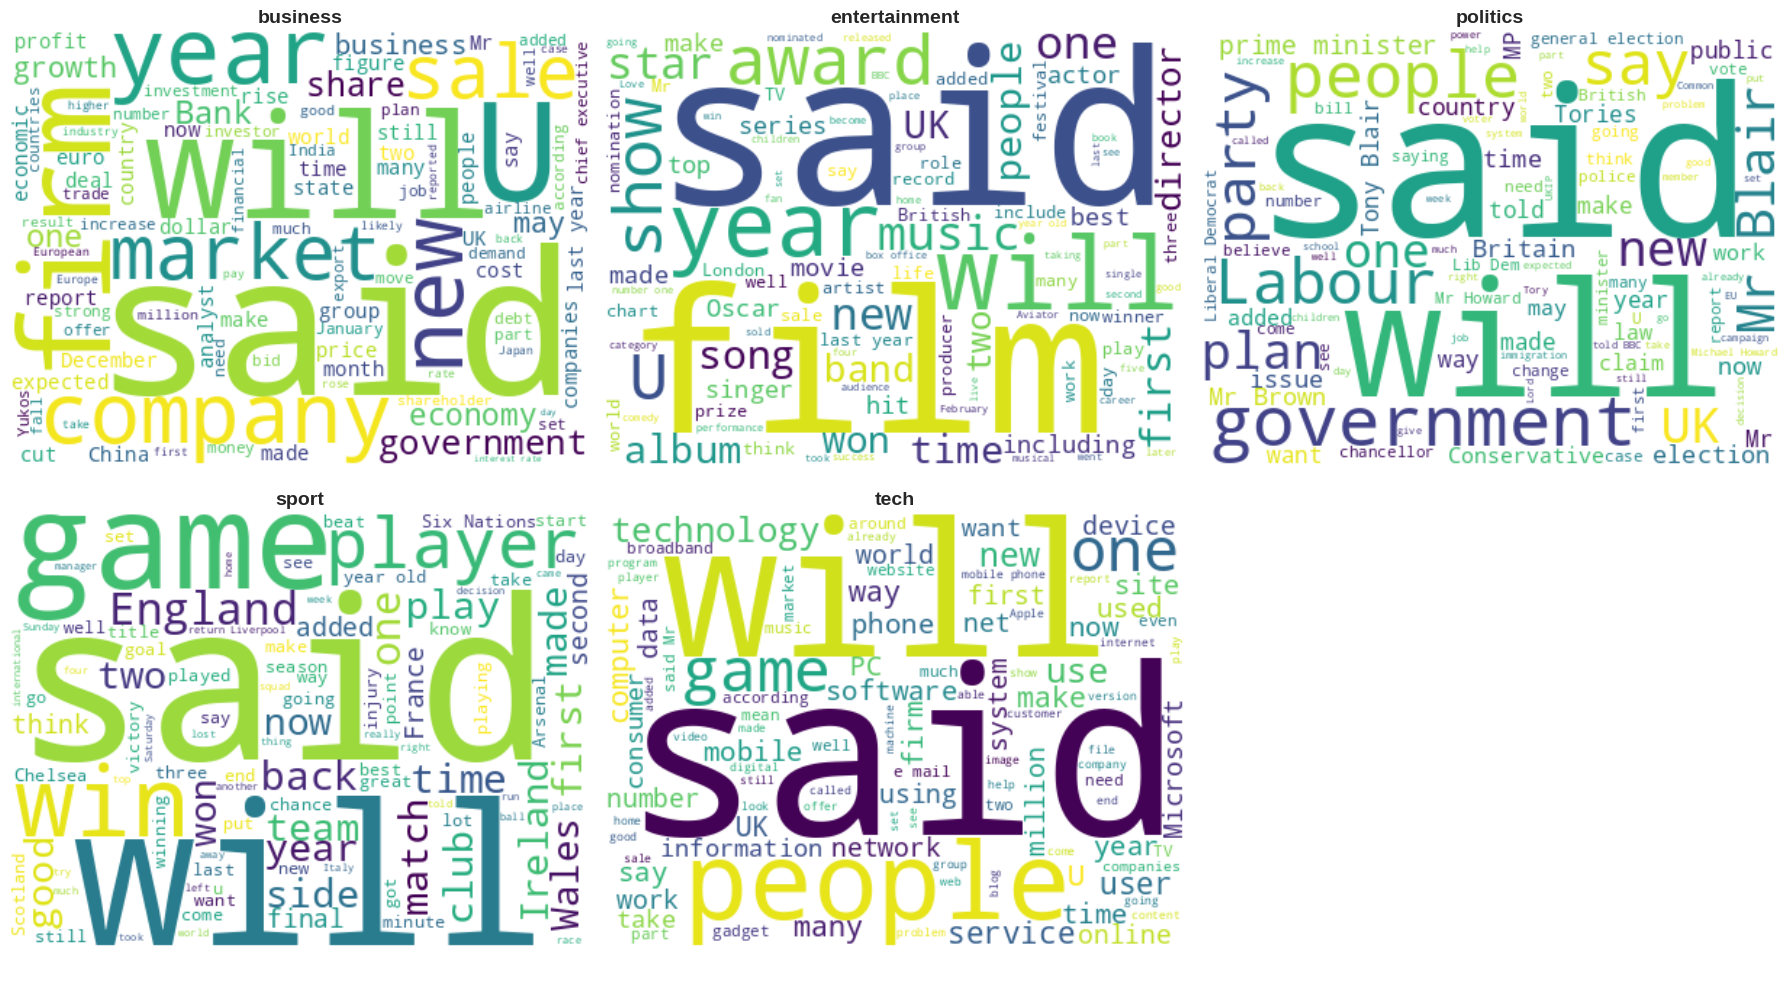

In [21]:
print("\n--- Generating Word Clouds for Each Category ---")

categories = df['Category'].unique()
n_categories = len(categories)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, category in enumerate(categories):
    text = ' '.join(df[df['Category'] == category]['Text'].values)
    wordcloud = WordCloud(width=400, height=300, background_color='white',
                         colormap='viridis', max_words=100).generate(text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{category}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

# Hide extra subplot if exists
if n_categories < len(axes):
    for idx in range(n_categories, len(axes)):
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [22]:
print("\n" + "="*70)
print("TEXT PREPROCESSING")
print("="*70)

class TextPreprocessor:
    """Comprehensive text preprocessing class"""
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
    
    def clean_text(self, text):
        """Clean and normalize text"""
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def tokenize_text(self, text):
        """Tokenize text into words"""
        return word_tokenize(text)
    
    def remove_stopwords(self, tokens):
        """Remove stopwords from tokens"""
        return [word for word in tokens if word not in self.stop_words]
    
    def lemmatize_tokens(self, tokens):
        """Lemmatize tokens"""
        return [self.lemmatizer.lemmatize(word) for word in tokens]
    
    def stem_tokens(self, tokens):
        """Stem tokens"""
        return [self.stemmer.stem(word) for word in tokens]
    
    def preprocess(self, text, use_stemming=False):
        """Complete preprocessing pipeline"""
        # Clean text
        text = self.clean_text(text)
        
        # Tokenize
        tokens = self.tokenize_text(text)
        
        # Remove stopwords
        tokens = self.remove_stopwords(tokens)
        
        # Lemmatize or stem
        if use_stemming:
            tokens = self.stem_tokens(tokens)
        else:
            tokens = self.lemmatize_tokens(tokens)
        
        # Join tokens back to string
        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing
print("\nApplying preprocessing to all texts...")
df['cleaned_text'] = df['Text'].apply(lambda x: preprocessor.preprocess(x, use_stemming=False))

print("\n--- Before and After Preprocessing Examples ---")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {df['Text'].iloc[i][:200]}...")
    print(f"Cleaned: {df['cleaned_text'].iloc[i][:200]}...")

# Analyze cleaned text
df['cleaned_word_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

print("\n--- Cleaned Text Statistics ---")
print(df['cleaned_word_count'].describe())


TEXT PREPROCESSING

Applying preprocessing to all texts...

--- Before and After Preprocessing Examples ---

Example 1:
Original:  Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google,...
Cleaned: quarterly profit u medium giant timewarner jumped bn £m three month december yearearlier firm one biggest investor google benefited sale highspeed internet connection higher advert sale timewarner sai...

Example 2:
Original:  The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.  And Alan Greenspan highlighted the US gover...
Cleaned: dollar hit highest level euro almost three month federal reserve head said u trade deficit set stabilise alan greenspan highlighted u government willingness curb spending rising household saving facto...

Example 3:
O

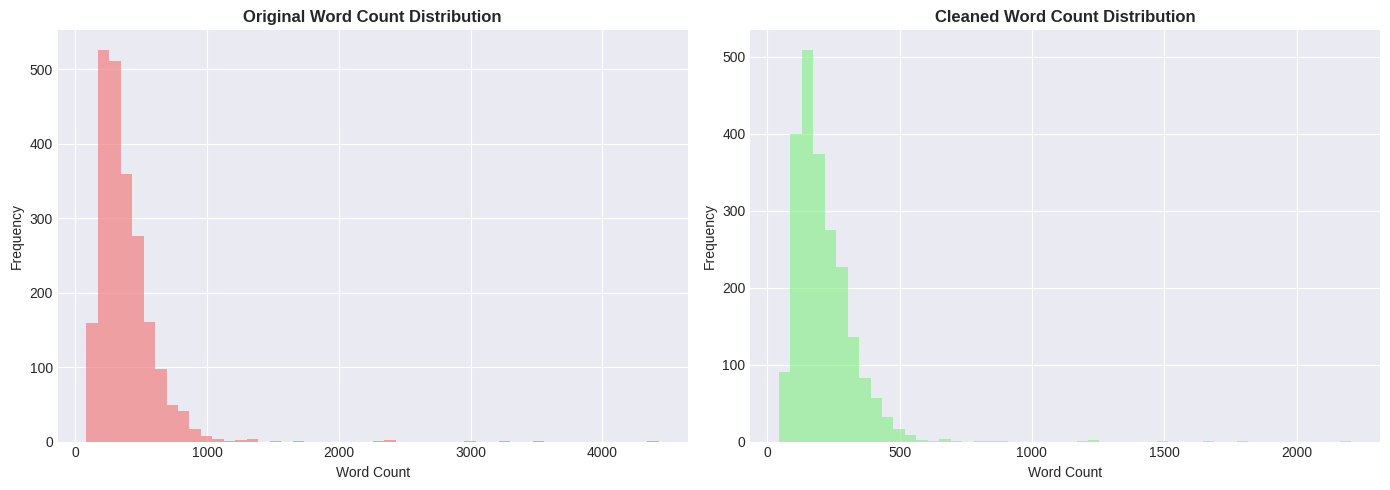


Average words removed: 166.16
Percentage reduction: 43.35%


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['word_count'], bins=50, color='lightcoral', alpha=0.7, label='Original')
axes[0].set_title('Original Word Count Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['cleaned_word_count'], bins=50, color='lightgreen', alpha=0.7, label='Cleaned')
axes[1].set_title('Cleaned Word Count Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nAverage words removed: {(df['word_count'] - df['cleaned_word_count']).mean():.2f}")
print(f"Percentage reduction: {((df['word_count'] - df['cleaned_word_count']) / df['word_count'] * 100).mean():.2f}%")


In [25]:
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Prepare data
X = df['cleaned_text']
y = df['Category']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nTarget classes: {label_encoder.classes_}")
print(f"Encoded values: {np.unique(y_encoded)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# TF-IDF Vectorization
print("\nApplying TF-IDF Vectorization...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),  # Unigrams and bigrams
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

# Top TF-IDF features
print("\n--- Top 20 TF-IDF Features ---")
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_train_tfidf.sum(axis=0).A1
top_indices = tfidf_scores.argsort()[-20:][::-1]
top_features = [(feature_names[i], tfidf_scores[i]) for i in top_indices]

for feature, score in top_features:
    print(f"{feature}: {score:.2f}")



FEATURE ENGINEERING

Target classes: ['business' 'entertainment' 'politics' 'sport' 'tech']
Encoded values: [0 1 2 3 4]

Training set size: 1780
Testing set size: 445

Applying TF-IDF Vectorization...
TF-IDF feature shape: (1780, 5000)
Number of features: 5000

--- Top 20 TF-IDF Features ---
year: 43.34
mr: 39.57
would: 38.06
also: 36.77
new: 34.19
one: 32.97
people: 32.69
last: 31.24
time: 29.86
could: 29.15
first: 28.80
two: 27.88
world: 27.67
game: 27.43
company: 26.47
say: 26.24
government: 25.30
uk: 24.39
make: 24.21
firm: 24.12


In [26]:
results = {}

# 6.1 Multinomial Naive Bayes
print("\n--- Training Multinomial Naive Bayes ---")
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)
results['Naive Bayes'] = nb_accuracy
print(f"Accuracy: {nb_accuracy * 100:.2f}%")



--- Training Multinomial Naive Bayes ---
Accuracy: 98.43%


In [27]:
# 6.2 Logistic Regression
print("\n--- Training Logistic Regression ---")
lr_model = LogisticRegression(max_iter=1000, C=10, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_pred)
results['Logistic Regression'] = lr_accuracy
print(f"Accuracy: {lr_accuracy * 100:.2f}%")



--- Training Logistic Regression ---
Accuracy: 99.10%


In [28]:
# 6.3 Random Forest
print("\n--- Training Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_pred)
results['Random Forest'] = rf_accuracy
print(f"Accuracy: {rf_accuracy * 100:.2f}%")


--- Training Random Forest ---
Accuracy: 97.30%


In [29]:
# 6.4 Support Vector Machine
print("\n--- Training Support Vector Machine ---")
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_pred)
results['SVM'] = svm_accuracy
print(f"Accuracy: {svm_accuracy * 100:.2f}%")


--- Training Support Vector Machine ---
Accuracy: 99.10%


In [30]:
# Compare all models
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df.to_string(index=False))


MODEL COMPARISON
              Model  Accuracy
Logistic Regression  0.991011
                SVM  0.991011
        Naive Bayes  0.984270
      Random Forest  0.973034


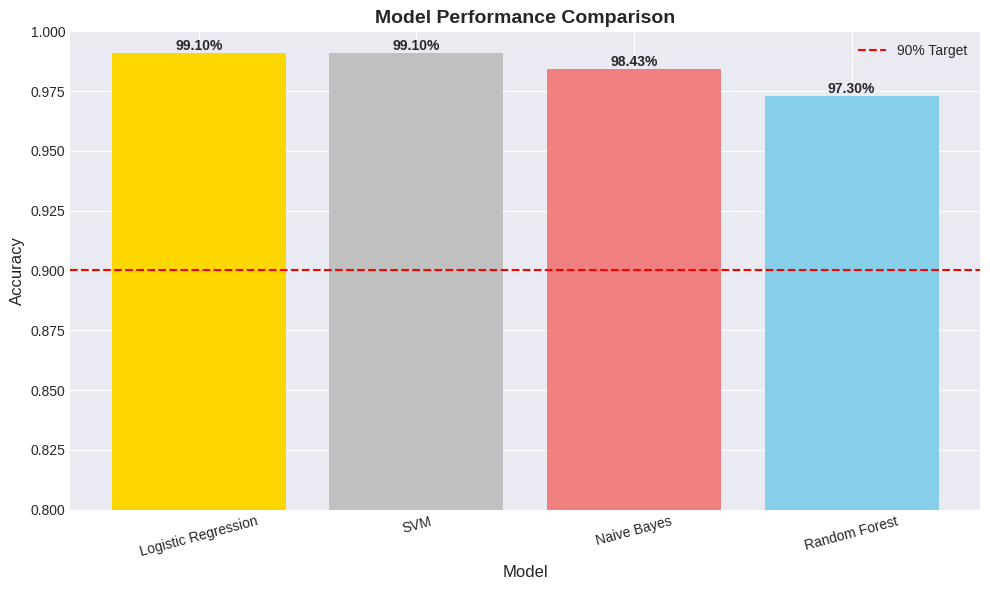

In [35]:
# Visualization: Model Comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['Accuracy'], color=['gold', 'silver', 'lightcoral', 'skyblue'])
plt.axhline(y=0.90, color='red', linestyle='--', label='90% Target')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.8, 1.0)
plt.xticks(rotation=15)
plt.legend()
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height*100:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [36]:
print("\n" + "="*70)
print("DETAILED EVALUATION - BEST MODEL")
print("="*70)

# Select best model (Logistic Regression typically performs best)
best_model = lr_model
best_pred = lr_pred

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, best_pred, 
                          target_names=label_encoder.classes_))


DETAILED EVALUATION - BEST MODEL

--- Classification Report ---
               precision    recall  f1-score   support

     business       1.00      0.98      0.99       102
entertainment       0.99      1.00      0.99        77
     politics       0.98      0.98      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.99      1.00      0.99        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



In [39]:
# Cross-validation
print("\n--- Cross-Validation Results ---")
cv_scores = cross_val_score(best_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Std CV Accuracy: {cv_scores.std() * 100:.2f}%")


--- Cross-Validation Results ---
CV Scores: [0.96629213 0.97752809 0.98314607 0.98033708 0.98595506]
Mean CV Accuracy: 97.87%
Std CV Accuracy: 0.68%


In [45]:
import joblib

joblib.dump(svm_model, 'svm_model.pkl')
print("SVM model saved as 'svm_model.pkl'")



SVM model saved as 'svm_model.pkl'


In [48]:
import joblib

joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("TF-IDF Vectorizer saved as 'tfidf_vectorizer.pkl'")


TF-IDF Vectorizer saved as 'tfidf_vectorizer.pkl'


In [50]:
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [40]:
def predict_news_category(text, model=best_model, vectorizer=tfidf_vectorizer, 
                         preprocessor=preprocessor, encoder=label_encoder):
    """Predict the category of a news article"""
    # Preprocess
    cleaned = preprocessor.preprocess(text)
    
    # Vectorize
    vectorized = vectorizer.transform([cleaned])
    
    # Predict
    prediction = model.predict(vectorized)[0]
    probabilities = model.predict_proba(vectorized)[0] if hasattr(model, 'predict_proba') else None
    
    # Decode
    category = encoder.inverse_transform([prediction])[0]
    
    return category, probabilities

# Test predictions
print("\n" + "="*70)
print("TESTING PREDICTIONS")
print("="*70)

test_samples = [
    "The stock market surged today as investors reacted positively to the latest economic data.",
    "Manchester United won the match 3-1 against their rivals in an exciting game.",
    "Scientists have discovered a new species of marine life in the deep ocean.",
    "The government announced new policies to tackle climate change.",
    "The latest smartphone from Apple features impressive camera capabilities."
]

for i, sample in enumerate(test_samples, 1):
    category, probs = predict_news_category(sample)
    print(f"\nSample {i}:")
    print(f"Text: {sample}")
    print(f"Predicted Category: {category}")
    if probs is not None:
        print("Probabilities:")
        for cat, prob in zip(label_encoder.classes_, probs):
            print(f"  {cat}: {prob*100:.2f}%")



TESTING PREDICTIONS

Sample 1:
Text: The stock market surged today as investors reacted positively to the latest economic data.
Predicted Category: business
Probabilities:
  business: 95.57%
  entertainment: 1.28%
  politics: 0.58%
  sport: 1.23%
  tech: 1.34%

Sample 2:
Text: Manchester United won the match 3-1 against their rivals in an exciting game.
Predicted Category: sport
Probabilities:
  business: 5.26%
  entertainment: 1.40%
  politics: 1.33%
  sport: 89.22%
  tech: 2.79%

Sample 3:
Text: Scientists have discovered a new species of marine life in the deep ocean.
Predicted Category: entertainment
Probabilities:
  business: 21.15%
  entertainment: 30.81%
  politics: 15.11%
  sport: 21.31%
  tech: 11.62%

Sample 4:
Text: The government announced new policies to tackle climate change.
Predicted Category: politics
Probabilities:
  business: 21.74%
  entertainment: 8.12%
  politics: 57.83%
  sport: 8.15%
  tech: 4.15%

Sample 5:
Text: The latest smartphone from Apple features impre

In [42]:
pip freeze> requirements.txt

Note: you may need to restart the kernel to use updated packages.
